In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel

In [2]:
import torchvision.transforms.functional as TF,torch.nn.functional as F
from miniai.datasets import *
from datasets import load_dataset,load_dataset_builder

In [3]:
from huggingface_hub import hf_hub_download
import json 

In [4]:
"GPU is there" if torch.cuda.is_available() else Exception("GPU is missing") 

'GPU is there'

Optional: Check if Container is paging

apt update && apt-get install sysstat && pidstat -r -d --human 3

# Loading Tiny-Imagenet

In [5]:
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name)

In [6]:
@inplace
def transformi(b): b[xl] = [TF.to_tensor(o)-0.0 for o in b[xl]]

bs = 32
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=7)

In [7]:
dt = dls.train
xb,yb = next(iter(dt))

In [8]:
# load the files
fp_json_pos2idx = hf_hub_download(repo_id=name, filename="dataset_infos.json", repo_type="dataset")
fp_idx2human = hf_hub_download(repo_id=name, filename="classes.py", repo_type="dataset")

In [9]:
f = open(fp_json_pos2idx,) 
data_pos2idx = json.load(f) 
f.close() 

In [10]:
# Repo provided a variable called 'i2d'
exec(open(fp_idx2human).read()) 
# Let's rename this variable to something suitable for this notebook
idx2human = i2d

In [11]:
pos2idx = data_pos2idx['Maysee--tiny-imagenet']['features']['label']['names']

In [12]:
pos2human = [idx2human[v] for k,v in enumerate(pos2idx)]

<Axes: >

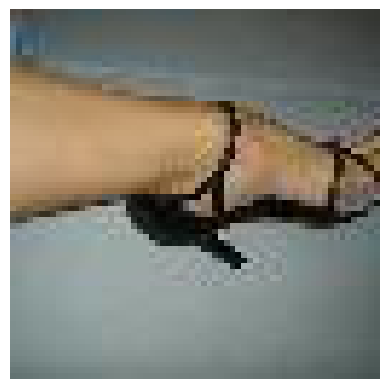

In [13]:
show_image(xb[17])

In [14]:
pos2human[yb[17]]

'sandal'

In [15]:
captions = ["A photo of " + txt for txt in pos2human]

In [16]:
captions[0:10]

['A photo of goldfish, Carassius auratus',
 'A photo of European fire salamander, Salamandra salamandra',
 'A photo of bullfrog, Rana catesbeiana',
 'A photo of tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 'A photo of American alligator, Alligator mississipiensis',
 'A photo of boa constrictor, Constrictor constrictor',
 'A photo of trilobite',
 'A photo of scorpion',
 'A photo of black widow, Latrodectus mactans',
 'A photo of tarantula']

In [17]:
len(captions)

200

In [18]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)

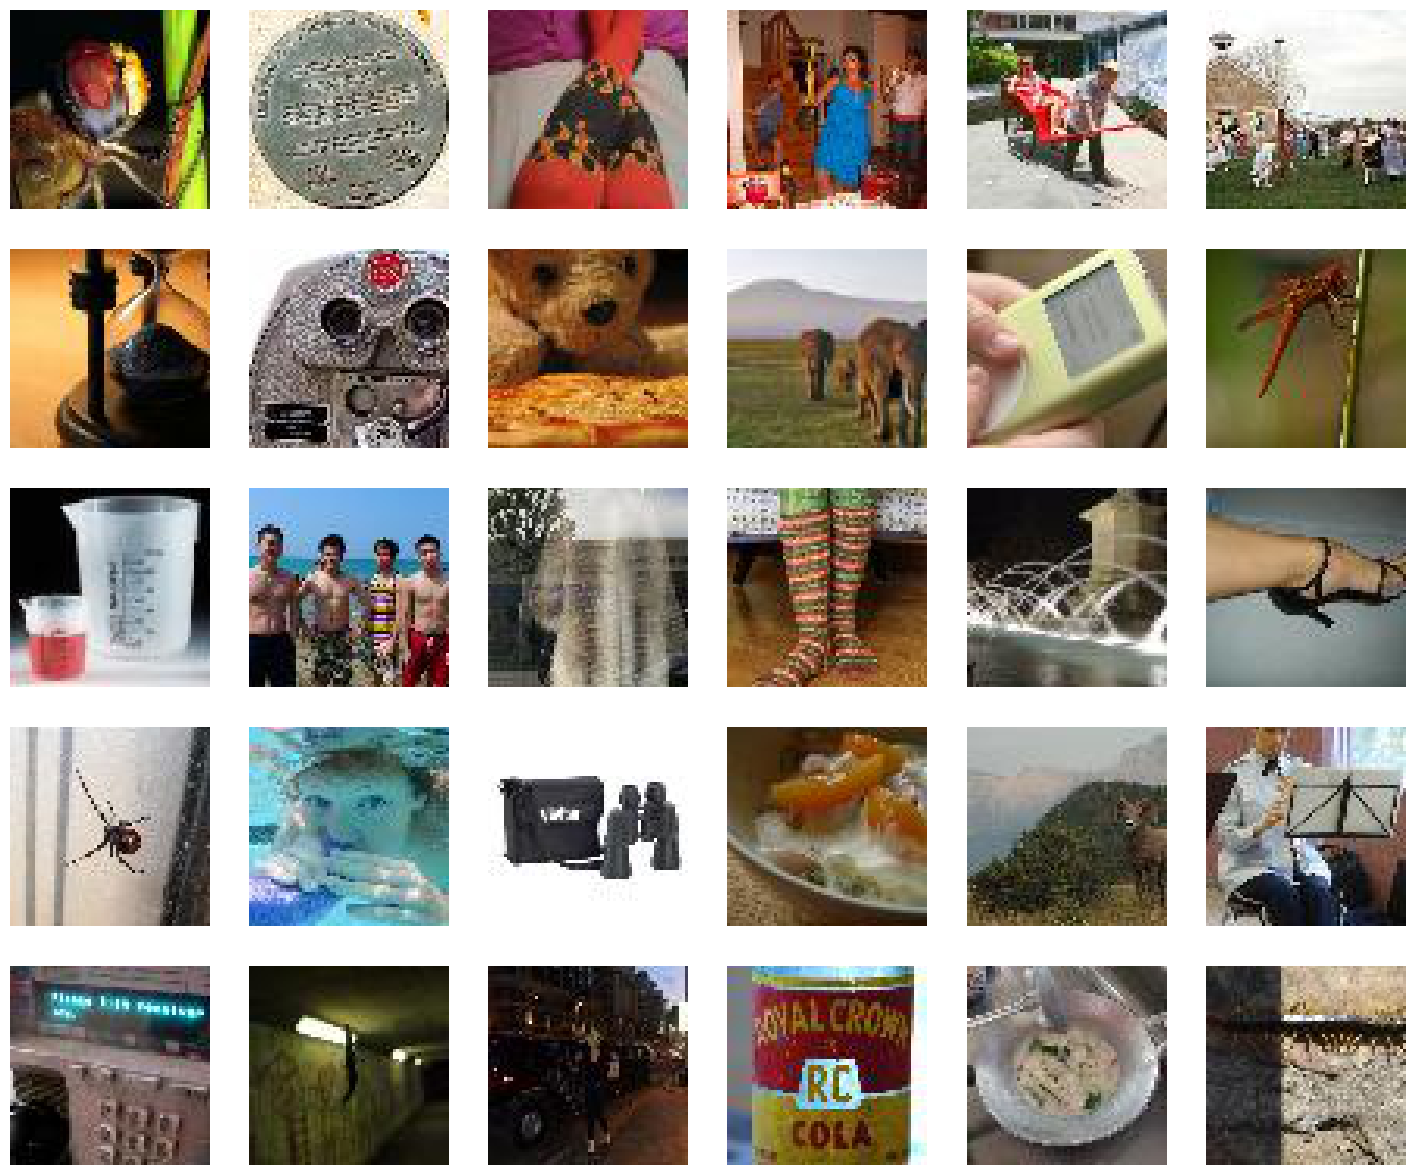

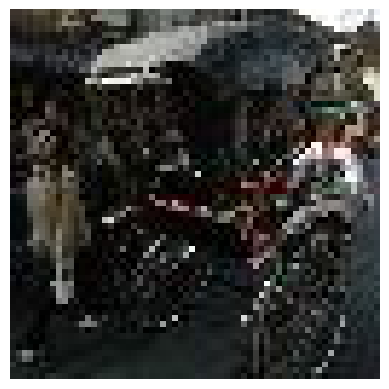

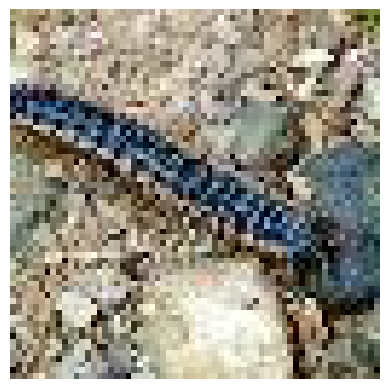

In [19]:
show_images(xb)

In [20]:
selected_image = xb[9]

In [21]:
inputs = processor(text=captions, images=selected_image, return_tensors="pt", padding=True)
image_input = inputs["pixel_values"].to("cuda")
text_inputs = inputs["input_ids"].to("cuda")
attention_mask = inputs["attention_mask"].to("cuda")

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [22]:
with torch.no_grad():
    # Compute the image and text embeddings
    image_features = model.get_image_features(image_input)
    text_features = model.get_text_features(input_ids=text_inputs, attention_mask=attention_mask)

# Normalize the features
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

In [23]:
# Compute similarity scores
similarity_scores = image_features @ text_features.T

# Get the index of the best matching text description
best_match_index = similarity_scores.argmax().item()

# Output the best matching text description
print(f"Best match: {captions[best_match_index]} (score: {similarity_scores[0, best_match_index]:.4f})")

Best match: A photo of reel (score: 0.2100)


<Axes: >

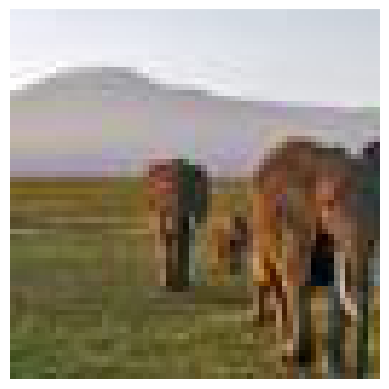

In [24]:
show_image(selected_image)